In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from preprocessing import crop_img

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [30]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 4
NUM_MODELS = 5
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 5
AE_EPOCHS = 10

### Loading Dataset

In [3]:
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder("./dataset/Training", transform=tfm)
test_ds  = datasets.ImageFolder("./dataset/Testing", transform=tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Training (Deep Ensemble of EfficientNet-B0 Models)

In [4]:
ensemble = []

for i in range(NUM_MODELS):
    model_i = models.efficientnet_b0(weights="IMAGENET1K_V1")
    model_i.classifier[1] = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280, NUM_CLASSES)
    )
    model_i.to(DEVICE)
    ensemble.append(model_i)

In [5]:
def train_model(model, train_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
    return model

In [6]:
os.makedirs("./saved_models", exist_ok=True)

for i in range(NUM_MODELS):
    print(f"Training model {i+1}/{NUM_MODELS}")
    ensemble[i] = train_model(ensemble[i], train_loader, EPOCHS)

    torch.save(
        ensemble[i].state_dict(),
        f"./saved_models/efficientnet_b0_model_{i}.pth"
    )
    print(f"Model {i+1} saved.\n")

Training model 1/5
Model 1 saved.

Training model 2/5
Model 2 saved.

Training model 3/5
Model 3 saved.

Training model 4/5
Model 4 saved.

Training model 5/5
Model 5 saved.



### Training (Autoencoder)

In [31]:
backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
backbone.classifier = nn.Identity()
backbone.to(DEVICE)
backbone.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim=1280, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [33]:
ae = EmbeddingAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [36]:
for epoch in range(AE_EPOCHS):
    ae.train()
    epoch_loss = 0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        with torch.no_grad():
            emb = backbone(x)  # extract embeddings
        optimizer.zero_grad()
        recon = ae(emb)
        loss = criterion(recon, emb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{AE_EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

os.makedirs("./saved_models", exist_ok=True)
torch.save(ae.state_dict(), "./saved_models/embedding_autoencoder.pth")
print("Autoencoder saved.")

Epoch 1/10, Loss: 0.0163
Epoch 2/10, Loss: 0.0157
Epoch 3/10, Loss: 0.0151
Epoch 4/10, Loss: 0.0150
Epoch 5/10, Loss: 0.0147
Epoch 6/10, Loss: 0.0142
Epoch 7/10, Loss: 0.0140
Epoch 8/10, Loss: 0.0139
Epoch 9/10, Loss: 0.0138
Epoch 10/10, Loss: 0.0135
Autoencoder saved.


### Loading Model Weights

In [37]:
def load_ensemble(num_models, num_classes, device, model_dir="./saved_models"):
    ensemble = []

    for i in range(num_models):
        model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

        model.load_state_dict(
            torch.load(
                f"{model_dir}/efficientnet_b0_model_{i}.pth",
                map_location=device
            )
        )

        model.to(device)
        model.eval()
        ensemble.append(model)

    print(f"Loaded {num_models} models from {model_dir}")
    return ensemble

def load_gatekeeper(device, model_dir="./saved_models"):
    ae = EmbeddingAutoencoder().to(device)
    ae.load_state_dict(
        torch.load(
            f"{model_dir}/embedding_autoencoder.pth",
            map_location=device
        )
    )
    ae.eval()
    print("Loaded embedding autoencoder gatekeeper.")
    return ae

In [38]:
ensemble = load_ensemble(NUM_MODELS, NUM_CLASSES, DEVICE)
ae = load_gatekeeper(DEVICE)

Loaded 5 models from ./saved_models
Loaded embedding autoencoder gatekeeper.


### Evaluation

In [9]:
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_ensemble(ensemble, test_loader):
    y_true, y_pred = [], []

    for x, y in test_loader:
        x = x.to(DEVICE)
        probs_list = []
        for model_i in ensemble:
            model_i.eval()
            with torch.no_grad():
                logits = model_i(x)
                probs = F.softmax(logits, dim=1)
                probs_list.append(probs)
        probs_stack = torch.stack(probs_list)
        mean_probs = probs_stack.mean(dim=0)
        preds = mean_probs.argmax(dim=1).cpu()

        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

    print("Accuracy:", accuracy_score(y_true, y_pred))

    plot_confusion(y_true, y_pred, test_ds.classes)

    print(
        "\nClassification Report:\n",
        classification_report(y_true, y_pred, target_names=test_ds.classes)
    )

Accuracy: 0.9977116704805492


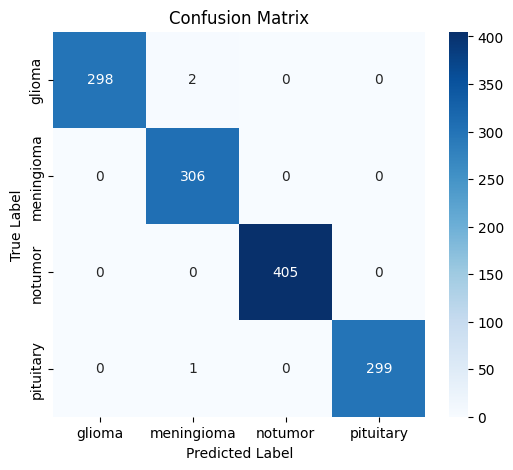


Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [10]:
evaluate_ensemble(ensemble, test_loader)

### Inference & Explainability

In [12]:
class GradCAM:
    def __init__(self, model, layer):
        self.grad = None
        self.act = None
        self.model = model
        layer.register_forward_hook(lambda m, i, o: setattr(self, "act", o))
        layer.register_backward_hook(lambda m, gi, go: setattr(self, "grad", go[0]))

    def __call__(self, x, class_idx):
        self.model.zero_grad()
        score = self.model(x)[0, class_idx]
        score.backward()

        w = self.grad.mean(dim=(2,3), keepdim=True)
        cam = (w * self.act).sum(dim=1).relu()
        cam = cam[0].detach().cpu().numpy()
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        return cam / (cam.max() + 1e-8)

def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def ensemble_predict_mc(img_path, ensemble, gradcam_model_idx=0, mc_passes=10):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)

    all_probs = []

    for model_i in ensemble:
        model_i.eval()
        enable_mc_dropout(model_i)  # keep ONLY dropout active
        
        probs_list = []
        for _ in range(mc_passes):
            logits = model_i(x)
            probs_list.append(F.softmax(logits, dim=1))

        probs_stack = torch.stack(probs_list)
        mean_probs = probs_stack.mean(dim=0)
        std_probs  = probs_stack.std(dim=0)
        all_probs.append((mean_probs, std_probs))

    # Stack ensemble results
    mean_probs_stack = torch.stack([p[0] for p in all_probs])
    std_probs_stack  = torch.stack([p[1] for p in all_probs])

    ensemble_mean = mean_probs_stack.mean(dim=0)
    ensemble_std  = std_probs_stack.mean(dim=0)

    pred_class = ensemble_mean.argmax(dim=1).item()
    pred_conf  = ensemble_mean.max().item()
    pred_uncertainty = ensemble_std.max().item()  # Epistemic uncertainty
    
    if pred_conf >= 0.90:
        risk = "HIGH confidence"
    elif pred_conf >= 0.80:
        risk = "MEDIUM confidence"
    else:
        risk = "LOW confidence"

    print(f"Predicted: {train_ds.classes[pred_class]} ({risk}: {pred_conf*100:.2f}%)")  # ensemble's belief in class (heuristic)
    print(f"Ensemble uncertainty (std across models): {pred_uncertainty:.4f}")
    
    gradcam_model = ensemble[gradcam_model_idx]
    gradcam_model.eval()
    gradcam = GradCAM(gradcam_model, gradcam_model.features[-1])
    cam = gradcam(x, pred_class)
    img_np = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    cv2.imshow("Grad-CAM", overlay)
    cv2.waitKey(0)

In [25]:
ensemble_predict_mc("./dataset/Testing/pituitary/Te-piTr_0002.jpg", ensemble, gradcam_model_idx=0)

Predicted: meningioma (MEDIUM confidence: 88.16%)
Ensemble uncertainty (std across models): 0.0348


### Checking Mislabeled Samples

In [28]:
ensemble_predict_mc("./ood/ball-2799545_1280-1752847675.jpg", ensemble, gradcam_model_idx=1)

Predicted: notumor (MEDIUM confidence: 85.70%)
Ensemble uncertainty (std across models): 0.0451


In [11]:
misclassified = []
start_idx = 0

for x, y in test_loader:
    x = x.to(DEVICE)
    batch_size = x.size(0)

    probs_list = []
    for model_i in ensemble:
        model_i.eval()
        with torch.no_grad():
            logits = model_i(x)
            probs = torch.softmax(logits, dim=1)
            probs_list.append(probs)
    probs_stack = torch.stack(probs_list)
    mean_probs = probs_stack.mean(dim=0)
    preds = mean_probs.argmax(dim=1).cpu()

    for i in range(batch_size):
        if preds[i] != y[i]:
            path = test_ds.samples[start_idx + i][0]
            misclassified.append((path, y[i].item(), preds[i].item()))

    start_idx += batch_size

# Display first 10 misclassified examples
for path, true, pred in misclassified[:10]:
    print(f"File: {path}, True: {test_ds.classes[true]}, Pred: {test_ds.classes[pred]}")


File: ./dataset/Testing\glioma\Te-gl_0232.jpg, True: glioma, Pred: meningioma
File: ./dataset/Testing\glioma\Te-gl_0259.jpg, True: glioma, Pred: meningioma
File: ./dataset/Testing\pituitary\Te-piTr_0002.jpg, True: pituitary, Pred: meningioma


### Inference on OOD Images

In [39]:
def gatekeeper(img_tensor, threshold=0.1):
    """
    img_tensor: single image, transformed (C,H,W)
    threshold: max reconstruction error allowed
    """
    ae.eval()
    backbone.eval()
    with torch.no_grad():
        x = img_tensor.unsqueeze(0).to(DEVICE)
        emb = backbone(x)
        recon = ae(emb)
        error = torch.mean((emb - recon)**2).item()
    if error <= threshold:
        return True, error  # valid brain MRI
    else:
        return False, error  # OOD

In [44]:
img = Image.open("./ood/brain-abscesses-in-cats-1-2852394107.jpg").convert("RGB")
img_t = tfm(img)
valid, recon_err = gatekeeper(img_t)
print(f"Valid MRI? {valid}, Reconstruction error: {recon_err:.4f}")

Valid MRI? False, Reconstruction error: 0.1323


In [48]:
user_img = "./dataset/Testing/glioma/Te-gl_0047.jpg"
# ./dataset/Testing/glioma/Te-gl_0047.jpg
# ./ood/ball-2799545_1280-1752847675.jpg

try:
    img = Image.open(user_img).convert("RGB")
    img_t = tfm(img)
    valid, recon_err = gatekeeper(img_t)
    if valid:
        print(f"Image passed gatekeeper check (Reconstruction error: {recon_err:.4f}).\nProceeding to ensemble prediction.\n")
        ensemble_predict_mc(user_img, ensemble, gradcam_model_idx=0)
    else:
        print(f"Image rejected by gatekeeper (Reconstruction error: {recon_err:.4f}).\nNot a valid brain MRI.")

except Exception as e:
    print(f"Error loading image: {e}")

Image passed gatekeeper check (Reconstruction error: 0.0165).
Proceeding to ensemble prediction.

Predicted: glioma (HIGH confidence: 98.11%)
Ensemble uncertainty (std across models): 0.0043
